# Name: Bennie Kibet
# Project :Terry Stops Analysis

## Business Understanding
## Overview:

In Terry v. Ohio, a landmark Supreme Court case in 1967-8, the court found that a police officer was not in violation of the "unreasonable search and seizure" clause of the Fourth Amendment, even though he stopped and frisked a couple of suspects only because their behavior was suspicious. Thus was born the notion of "reasonable suspicion", according to which an agent of the police may e.g. temporarily detain a person, even in the absence of clearer evidence that would be required for full-blown arrests etc. Terry Stops are stops made of suspicious drivers.

Therefore, to help the public department make reasonable judgements when prosecuting such cases they would like to have a model that identifies such cases to plan on how to deal with them.


## Problem Statement:

To identify whether arrests made after a Terry Stop, has undergone the procedure of being stopped on suspicious behaviour and frisked, or if other factors play a role in the arrest.

## Metrics:

The effectiveness of Terry Stops' predictive models will be evaluated based on the accuracy score. This metric measures the proportion of correctly predicted instances among all instances, providing insight into how well the models can predict arrest occuring after a Terry Stop. A higher accuracy score indicates that the models are more reliable in identifying the arrests made due to Terry Stops.

## Objectives
1. To predict whether an arrest was made after a Terry Stop
2. Arrest given information about the presence of weapons
3. The time of day of the call

## Data collection

### Importing libraries

In [3]:
# import relevant libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, classification_report, accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.feature_selection import SelectFromModel 
from sklearn.linear_model import LogisticRegressionCV
import math


### Data Understanding

In [4]:
df = pd.read_csv('Terry_Stops_20240825.csv')
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,36 - 45,-1,20160000398323,208373,Offense Report,None,4852,1953,M,Asian,...,15:18:00.0000000,TRESPASS,--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3
1,18 - 25,-1,20180000227180,559146,Citation / Infraction,None,5472,1964,M,Asian,...,00:07:00.0000000,"SUSPICIOUS PERSON, VEHICLE, OR INCIDENT",--TRAFFIC - BICYCLE VIOLATION,911,SOUTHWEST PCT - 3RD WATCH - F/W RELIEF,N,N,Southwest,F,F3
2,18 - 25,-1,20180000410091,498246,Offense Report,None,6081,1962,M,White,...,02:56:00.0000000,"NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)",--SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,911,NORTH PCT 3RD W - BOY (JOHN) - PLATOON 1,N,N,North,B,B1
3,-,-1,20160000001637,146742,Field Contact,None,6924,1974,M,White,...,01:44:00.0000000,-,-,-,EAST PCT OPS - NIGHT ACT,N,N,East,C,C1
4,46 - 55,-1,20150000006037,104477,Field Contact,None,6732,1975,M,White,...,02:59:00.0000000,-,-,-,SOUTH PCT 3RD W - SAM - PLATOON 2,N,N,North,B,B2


In [5]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat'],
      dtype='object')

In [6]:
#checking data  shape
df.shape
print('Number of rows =', df.shape[0])
print('Number of columns =', df.shape[1])

Number of rows = 61009
Number of columns = 23


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61009 entries, 0 to 61008
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         61009 non-null  object
 1   Subject ID                61009 non-null  int64 
 2   GO / SC Num               61009 non-null  int64 
 3   Terry Stop ID             61009 non-null  int64 
 4   Stop Resolution           61009 non-null  object
 5   Weapon Type               61009 non-null  object
 6   Officer ID                61009 non-null  object
 7   Officer YOB               61009 non-null  int64 
 8   Officer Gender            61009 non-null  object
 9   Officer Race              61009 non-null  object
 10  Subject Perceived Race    61009 non-null  object
 11  Subject Perceived Gender  61009 non-null  object
 12  Reported Date             61009 non-null  object
 13  Reported Time             61009 non-null  object
 14  Initial Call Type     

### Summary of features
1. Subject Age Group: Subject Age Group (10 year increments) as reported by the officer.
2. Subject ID: Key, generated daily, identifying unique subjects in the dataset using a character to character match of first name and last name.
3. GO / SC Num: General Offense or Street Check number, relating the Terry Stop to the parent report.
4. Terry Stop ID: Key identifying unique Terry Stop reports.
5. Stop Resolution: Resolution of the stop as reported by the officer.
6. Weapon Type: Type of weapon, if any, identified during a search or frisk of the subject.
7. Officer ID: Key identifying unique officers in the dataset.
8. Officer YOB: Year of birth, as reported by the officer.
9. Officer Gender: Gender of the officer, as reported by the officer.
10. Officer Race: Race of the officer, as reported by the officer.
11. Subject Perceived Race: Perceived race of the subject, as reported by the officer.
12. Subject Perceived Gender: Perceived gender of the subject, as reported by the officer.
13. Reported Date: Date the report was filed in the Records Management System (RMS).
14. Reported Time: Time the stop was reported in the Records Management System (RMS).
15. Initial Call Type: Initial classification of the call as assigned by 911.
16. Final Call Type: Final classification of the call as assigned by the primary officer closing the event.
17. Call Type: How the call was received by the communication center.
18. Officer Squad: Functional squad assignment (not budget) of the officer as reported by the Data Analytics Platform (DAP).
19. Arrest Flag: Indicator of whether a "physical arrest" was made, of the subject, during the Terry Stop. Does not necessarily reflect a report of an arrest in the Records Management System (RMS).
20. Frisk Flag: Indicator of whether a "frisk" was conducted, by the officer, of the subject, during the Terry Stop.
21. Precinct: Precinct of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.
22. Sector: Sector of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.
23. Beat: Beat of the address associated with the underlying Computer Aided Dispatch (CAD) event. Not necessarily where the Terry Stop occurred.


## Checking for null values

In [8]:
df.drop(columns=['Sector','Beat'],axis=1,inplace=True)

The sector and beat columns are dropped as they are not where the stops occured.

In [9]:
# To convert the missing values in the data into nan type
df.replace('-', np.nan, inplace=True)

In [10]:
# To check number of null values in each column
df.isnull().sum()

Subject Age Group            2200
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 24571
Officer ID                     24
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race       1816
Subject Perceived Gender      243
Reported Date                   0
Reported Time                   0
Initial Call Type           13477
Final Call Type             13477
Call Type                   13477
Officer Squad                 561
Arrest Flag                     0
Frisk Flag                    478
Precinct                    10621
dtype: int64

The dataset contains a significant number of NaN values relative to its size in some columns(61,009 entries).

    The output indicates the count of missing values (NaN or null values) for each column in the dataset:

    Subject Age Group has 2200 missing values.
    Weapon Type has 24571 missing values.
    Officer ID has 24 missing values.
    Subject Perceived Race has 1816 missing values.
    Subject Perceived Gender has 243 missing values.
    Initial Call Type has 13477 missing values.
    Final Call Type has 13477 missing values.
    Call Type has 13477 missing values.
    Officer Squad  has 561 missing values.
    Frisk Flag has 478 missing values.


In [11]:
# As the percentage of missing values in Officer ID is very small it is easier to drop the rows(23) containing the nan value. 
df.dropna(subset=['Officer ID'], inplace= True)

In [12]:
df.isna().sum()

Subject Age Group            2196
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 24547
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race       1808
Subject Perceived Gender      240
Reported Date                   0
Reported Time                   0
Initial Call Type           13453
Final Call Type             13453
Call Type                   13453
Officer Squad                 537
Arrest Flag                     0
Frisk Flag                    478
Precinct                    10621
dtype: int64

In [13]:
def missing_data(df, column):
    length_of_df=len(df)                                                    
    missing_data= column.isna().sum()                                       
    percentage_of_missing_data = round((missing_data/length_of_df*100),2)   
    return print(f"Percentage of Missing Data: {percentage_of_missing_data}""%")

In [14]:
missing_data(df,df['Officer Squad'])

Percentage of Missing Data: 0.88%


In [15]:
missing_data(df,df['Weapon Type'])

Percentage of Missing Data: 40.25%


In [16]:
missing_data(df,df['Subject Perceived Race'])

Percentage of Missing Data: 2.96%


In [17]:
missing_data(df,df['Subject Perceived Gender'])

Percentage of Missing Data: 0.39%


In [18]:
missing_data(df,df['Initial Call Type'])

Percentage of Missing Data: 22.06%


In [19]:
missing_data(df,df['Final Call Type'])

Percentage of Missing Data: 22.06%


In [20]:
missing_data(df,df['Call Type'])

Percentage of Missing Data: 22.06%


In [21]:
missing_data(df,df['Precinct'])

Percentage of Missing Data: 17.42%


In [23]:
# Function to replace nulls in officer squad column with the mode of officer squad for the same precinct
def replace_null_with_mode(df, target_col, group_col):
    # Iterating through the rows with null values in the target column
    for index, row in df[df[target_col].isnull()].iterrows():
        # Getting the corresponding group value (zipcode)
        group_value = row[group_col]
        # Filtering the DataFrame to include only rows with the same group value and non-null target values
        filtered_df = df[(df[group_col] == group_value) & df[target_col].notnull()]
        # Getting the mode of the target column in the filtered DataFrame
        mode_value = filtered_df[target_col].mode()
        # Checking if mode_value is not empty
        if not mode_value.empty:
            # Replacing the null value with the mode value
            df.at[index, target_col] = mode_value[0]
    return df

# Replacing nulls in columns with the mode of columns for the same precinct
df = replace_null_with_mode(df, 'Officer Squad', 'Officer ID')
df = replace_null_with_mode(df, 'Weapon Type', 'Officer ID')
df = replace_null_with_mode(df, 'Subject Perceived Race', 'Officer ID')
df = replace_null_with_mode(df, 'Subject Perceived Gender', 'Officer ID')


In [25]:
df = replace_null_with_mode(df,'Initial Call Type','Officer ID')
df = replace_null_with_mode(df,'Final Call Type','Officer ID')
df = replace_null_with_mode(df,'Call Type','Officer ID')

In [72]:
df = replace_null_with_mode(df,'Subject Age Group','Officer ID')

In [26]:
df.isna().sum()

Subject Age Group           2196
Subject ID                     0
GO / SC Num                    0
Terry Stop ID                  0
Stop Resolution                0
Weapon Type                 1219
Officer ID                     0
Officer YOB                    0
Officer Gender                 0
Officer Race                   0
Subject Perceived Race         6
Subject Perceived Gender       1
Reported Date                  0
Reported Time                  0
Initial Call Type            171
Final Call Type              171
Call Type                    171
Officer Squad                 69
Arrest Flag                    0
Frisk Flag                   478
Precinct                      44
dtype: int64

### Checking for duplicates

In [27]:
# To check for duplicates
df.duplicated().sum()

0

### Further EDA

In [28]:
df['Weapon Type'].value_counts()

None                                    46129
Knife/Cutting/Stabbing Instrument       10030
Lethal Cutting Instrument                1484
Handgun                                   865
Blunt Object/Striking Implement           412
Firearm                                   409
Other Firearm                             124
Firearm Other                             100
Mace/Pepper Spray                          56
Club, Blackjack, Brass Knuckles            49
None/Not Applicable                        29
Taser/Stun Gun                             18
Firearm (unk type)                         15
Fire/Incendiary Device                     13
Rifle                                      11
Club                                        9
Shotgun                                     6
Personal Weapons (hands, feet, etc.)        2
Automatic Handgun                           2
Brass Knuckles                              1
Blackjack                                   1
Poison                            

In [29]:
df['Weapon Type'].replace(to_replace=['None/Not Applicable','Firearm Other','Other Firearm'], value=['None','Firearm','Firearm'], inplace=True)

In [30]:
df['Weapon Type'].value_counts()

None                                    46158
Knife/Cutting/Stabbing Instrument       10030
Lethal Cutting Instrument                1484
Handgun                                   865
Firearm                                   633
Blunt Object/Striking Implement           412
Mace/Pepper Spray                          56
Club, Blackjack, Brass Knuckles            49
Taser/Stun Gun                             18
Firearm (unk type)                         15
Fire/Incendiary Device                     13
Rifle                                      11
Club                                        9
Shotgun                                     6
Automatic Handgun                           2
Personal Weapons (hands, feet, etc.)        2
Brass Knuckles                              1
Blackjack                                   1
Poison                                      1
Name: Weapon Type, dtype: int64

In [31]:
df['Has Weapon'] = df['Weapon Type'].apply(lambda x: 0 if x == 'None' else 1)

In [32]:
df.drop('Weapon Type',axis=1,inplace=True)

In [33]:
df['Frisk Flag'].value_counts()

N    45911
Y    14596
Name: Frisk Flag, dtype: int64

In [34]:
df['Frisk Flag'].replace(to_replace=['N', '-', 'Y'], value=[0,0,1], inplace=True)

In [35]:
df['Frisk Flag'].value_counts()

0.0    45911
1.0    14596
Name: Frisk Flag, dtype: int64

In [36]:
df['Officer YOB'].value_counts()

1986    4024
1987    3790
1991    3415
1992    3284
1984    3145
1990    3082
1989    2964
1985    2852
1988    2591
1995    2327
1993    2180
1982    2060
1983    2021
1979    1885
1994    1763
1981    1712
1976    1368
1996    1339
1971    1312
1978    1263
1977    1153
1997    1093
1973    1084
1980    1000
1967     843
1970     724
1968     692
1975     655
1969     618
1974     603
1972     483
1964     472
1962     465
1965     424
1998     382
1963     265
1961     263
1966     248
1958     223
1959     174
1960     161
1999     124
2000     103
1900      76
2001      60
1954      44
1957      43
1953      38
2002      29
1955      21
1956      17
1948      11
1952       9
1949       5
1946       2
1951       1
Name: Officer YOB, dtype: int64

In this case 1 shows whether a frisk was done while 0 is that none was done.

In [37]:
df['Arrest Flag'].value_counts()

N    54406
Y     6579
Name: Arrest Flag, dtype: int64

In [38]:
df['Arrest Flag'].replace(to_replace=['N','Y'], value=[0,1], inplace=True)

In [39]:
df['Arrest Flag'].value_counts()

0    54406
1     6579
Name: Arrest Flag, dtype: int64

In [40]:
df['Reported Date'] = pd.to_datetime(df['Reported Date'])
df['Reported Time'] = pd.to_datetime(df['Reported Time'])

In [41]:
df['Officer ID'].value_counts()

7456    530
7773    367
7634    360
7690    359
8646    351
       ... 
6162      1
6363      1
8876      1
5983      1
6342      1
Name: Officer ID, Length: 1382, dtype: int64

In [42]:
df.nunique()

Subject Age Group               6
Subject ID                  16989
GO / SC Num                 48828
Terry Stop ID               60883
Stop Resolution                 5
Officer ID                   1382
Officer YOB                    56
Officer Gender                  3
Officer Race                    9
Subject Perceived Race         10
Subject Perceived Gender        6
Reported Date                3449
Reported Time               23667
Initial Call Type             180
Final Call Type               195
Call Type                       6
Officer Squad                 270
Arrest Flag                     2
Frisk Flag                      2
Precinct                        8
Has Weapon                      2
dtype: int64

In [43]:
df['Subject Perceived Gender'].value_counts()

Male                                                         48381
Female                                                       12130
Unable to Determine                                            326
Unknown                                                        100
Gender Diverse (gender non-conforming and/or transgender)       45
MULTIPLE SUBJECTS                                                2
Name: Subject Perceived Gender, dtype: int64

In [44]:
df['Subject Perceived Gender'].replace(to_replace=['Male','Female','Unable to Determine','Unknown','Gender Diverse (gender non-conforming and/or transgender)','MULTIPLE SUBJECTS'],value=[0,1,2,2,2,2],inplace=True)

In [45]:
df['Officer Gender'].value_counts()

M    54072
F     6907
N        6
Name: Officer Gender, dtype: int64

In [46]:
df['Officer Gender'].replace(to_replace=['M','F','N'],value=[0,1,2],inplace=True)

In [47]:
df['Officer Gender'].value_counts()

0    54072
1     6907
2        6
Name: Officer Gender, dtype: int64

In [50]:
df['Subject Perceived Gender'].value_counts()

0.0    48381
1.0    12130
2.0      473
Name: Subject Perceived Gender, dtype: int64

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60985 entries, 0 to 61008
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Subject Age Group         58789 non-null  object             
 1   Subject ID                60985 non-null  int64              
 2   GO / SC Num               60985 non-null  int64              
 3   Terry Stop ID             60985 non-null  int64              
 4   Stop Resolution           60985 non-null  object             
 5   Officer ID                60985 non-null  object             
 6   Officer YOB               60985 non-null  int64              
 7   Officer Gender            60985 non-null  int64              
 8   Officer Race              60985 non-null  object             
 9   Subject Perceived Race    60979 non-null  object             
 10  Subject Perceived Gender  60984 non-null  float64            
 11  Reported Date  

In [52]:
# Splitting the columns based on variable types
categorical_columns = []
numerical_columns = []
for i in df.columns:
    if df[i].dtype == 'O':
        categorical_columns.append(i)
    else:
        numerical_columns.append(i)
        
print(f"Categorical columns:",  categorical_columns) 
print(f"Numerical columns:",  numerical_columns) 

Categorical columns: ['Subject Age Group', 'Stop Resolution', 'Officer ID', 'Officer Race', 'Subject Perceived Race', 'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad', 'Precinct']
Numerical columns: ['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Officer YOB', 'Officer Gender', 'Subject Perceived Gender', 'Reported Date', 'Reported Time', 'Arrest Flag', 'Frisk Flag', 'Has Weapon']


## Visualization of relationship

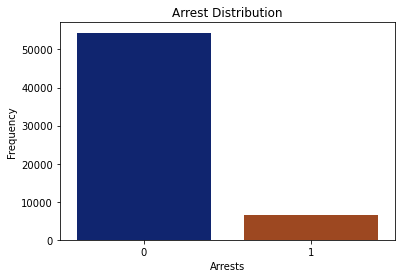

0    54406
1     6579
Name: Arrest Flag, dtype: int64


In [54]:
# Distribution of Arrests

sns.countplot(x='Arrest Flag', data=df, palette='dark')
plt.title('Arrest Distribution')
plt.xlabel('Arrests')
plt.ylabel('Frequency')
plt.show()

print(df['Arrest Flag'].value_counts())

>From the above plot the number of arrests made were few after a terry stop

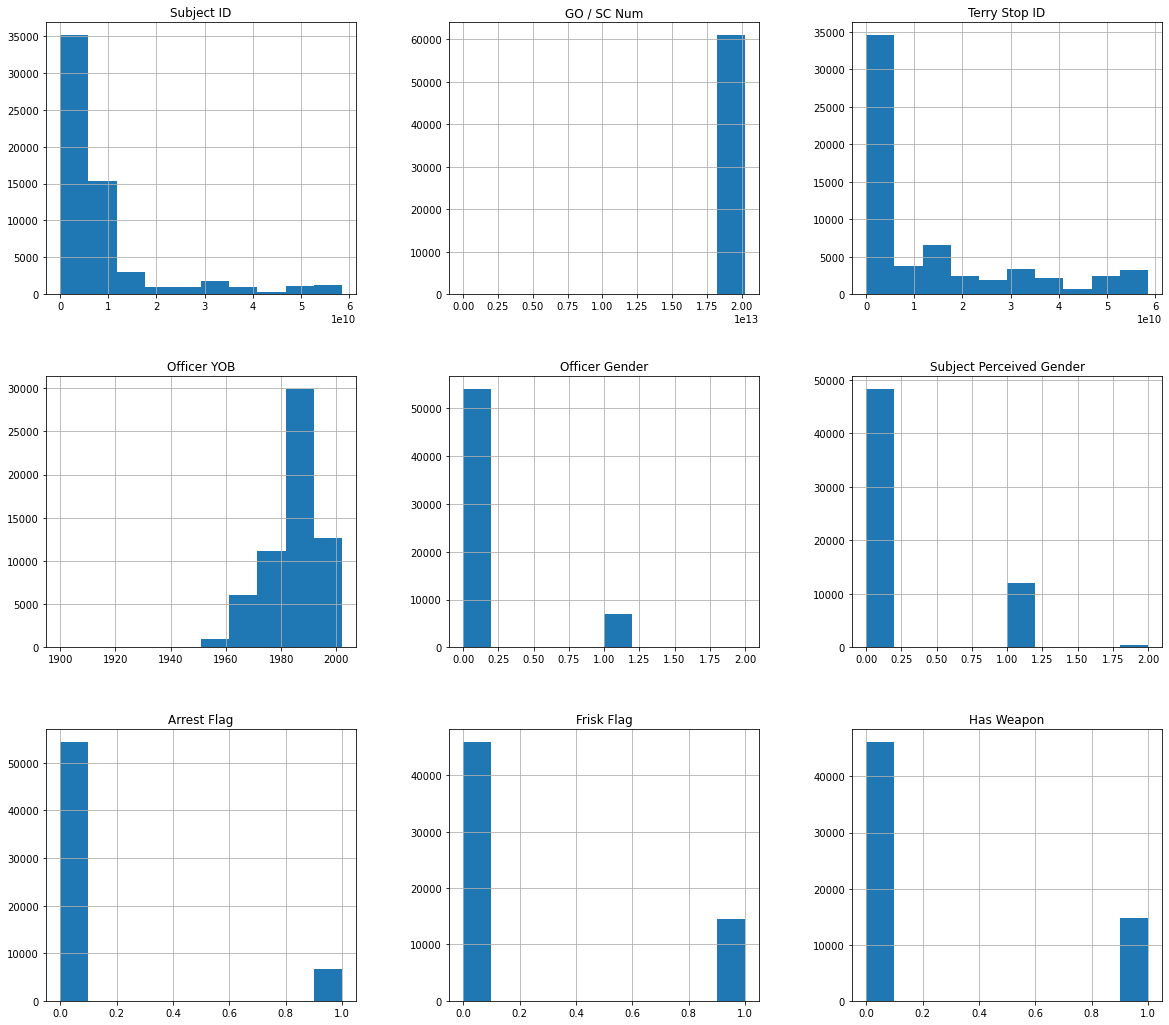

In [55]:
df.hist(figsize = (20,18));

## Discussion
* Subject ID, GO / SC Num, Terry Stop ID: These graphs show the frequency distribution of different identifiers. The high counts in certain categories might indicate common occurrences or frequent subjects in the dataset.
* Officer YOB, Officer Gender, Subject Perceived Gender: These graphs provide insights into the demographics of officers and subjects. For example, the distribution of officer birth years (YOB) can reveal the age range of the workforce, while gender distributions can highlight diversity or lack thereof.
* Arrest Flag, Frisk Flag, Weapon: These graphs show the frequency of arrests, frisks, and weapon findings. High counts in these categories could indicate areas with more law enforcement activity or higher crime rates.

## Checking for outliers

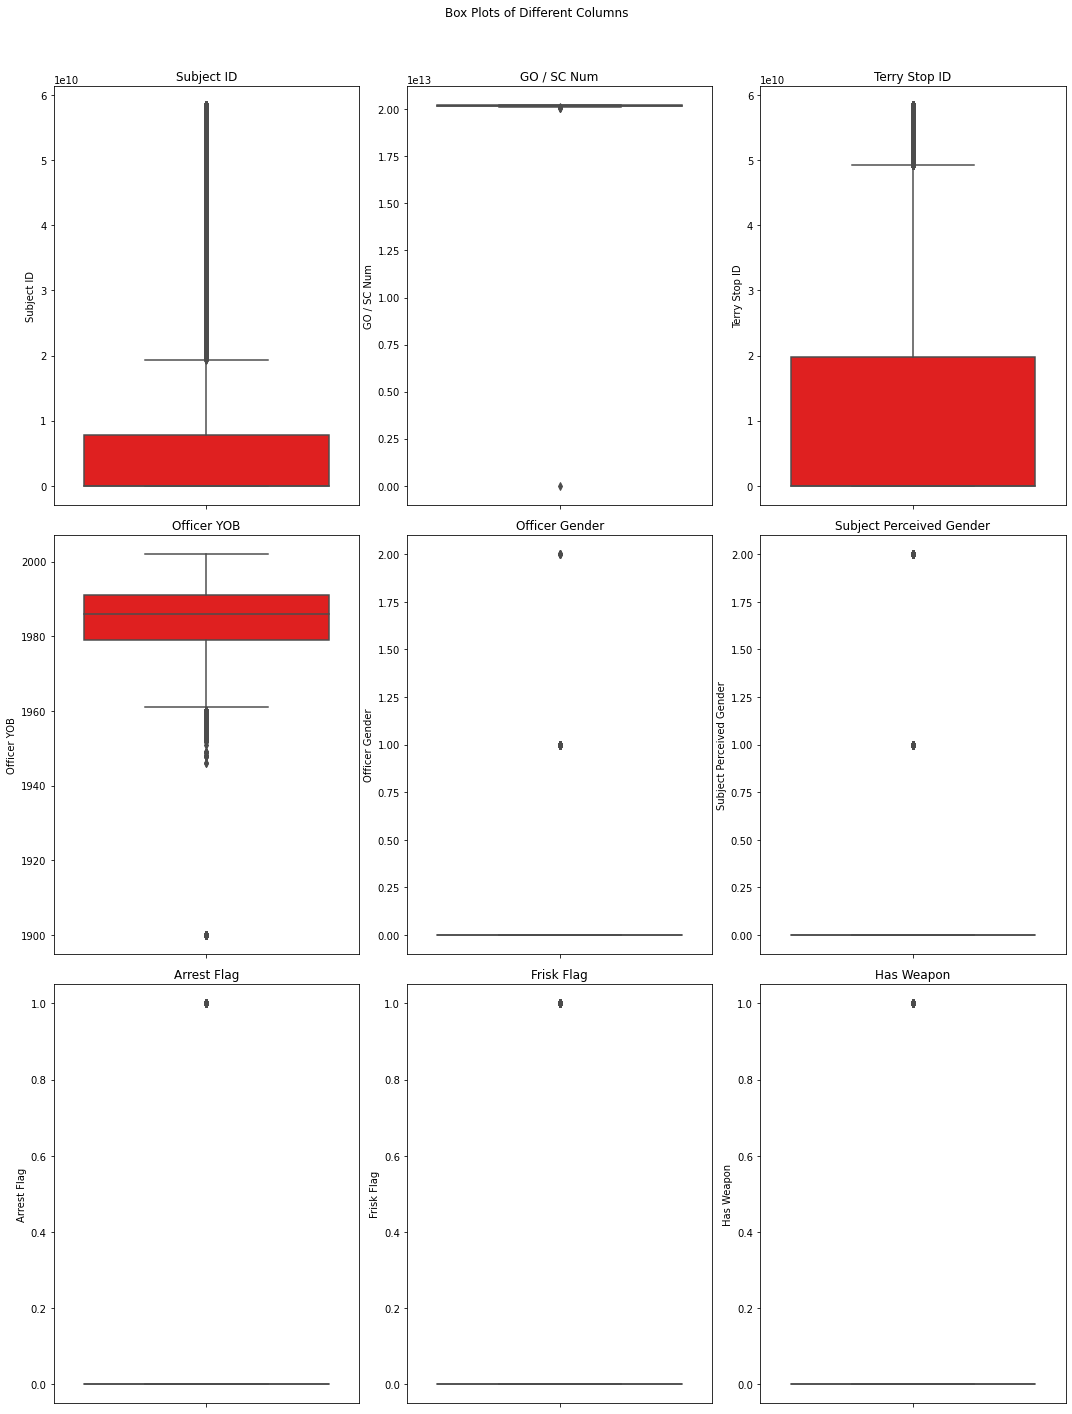

In [67]:
# Define the function for plotting boxplots
def boxplot_graph(df1, number_of_columns, columns_to_plot):
    # Ensure columns to plot are numeric
    numeric_columns = df1[columns_to_plot].select_dtypes(include='number').columns.tolist()
    
    # Check if there are numeric columns to plot
    if not numeric_columns:
        print("No numeric columns to plot.")
        return
    
    # Creating subplots
    num_columns = len(numeric_columns)

    # Number of rows and columns for subplots
    ncols = number_of_columns
    nrows = math.ceil(num_columns / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 20))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plotting each column in a separate subplot
    for i, column in enumerate(numeric_columns):
        sns.boxplot(y=df1[column], color="r", ax=axes[i])
        axes[i].set_title(column)

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust the layout to add space between rows
    plt.subplots_adjust(hspace=3) 

    plt.suptitle('Box Plots of Different Columns')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the main title
    plt.show()

# Example usage
# Assuming `df` is your DataFrame and `numerical_columns` is a list of columns to plot
boxplot_graph(df, 3, numerical_columns)


## Discussion

* Subject ID and Terry Stop ID: These box plots show the distribution of identifiers. The median and interquartile range (IQR) indicate the central tendency and variability. Outliers, if any, can highlight unusual cases.
* Officer YOB and Officer Gender: These plots provide insights into the demographics of officers. The distribution of birth years (YOB) can reveal the age range, while gender distribution can highlight diversity.
* Arrest Flag and Subject Perceived Gender: These plots show the frequency of arrests and perceived gender of subjects. The median values and IQRs can indicate common trends and variability in these categories.
* Frisk Flag and Has Weapon: The individual points plotted for these categories can indicate the frequency and distribution of frisks and weapon findings.

But considering this is based on real data we will avoid removing outliers as it will not give accurate insight to the dataset



*Bivariate Analysis*

In this section, we will perform bivariate analysis to examine the relationship between the target variable - price and the other numeric and continuous features in the data. We will use scatter plots to show the direction, strength, and shape of the relationship between two numeric variables. This will help us understand how one variable affects or is affected by another variable and identify any patterns or trends that may exist.

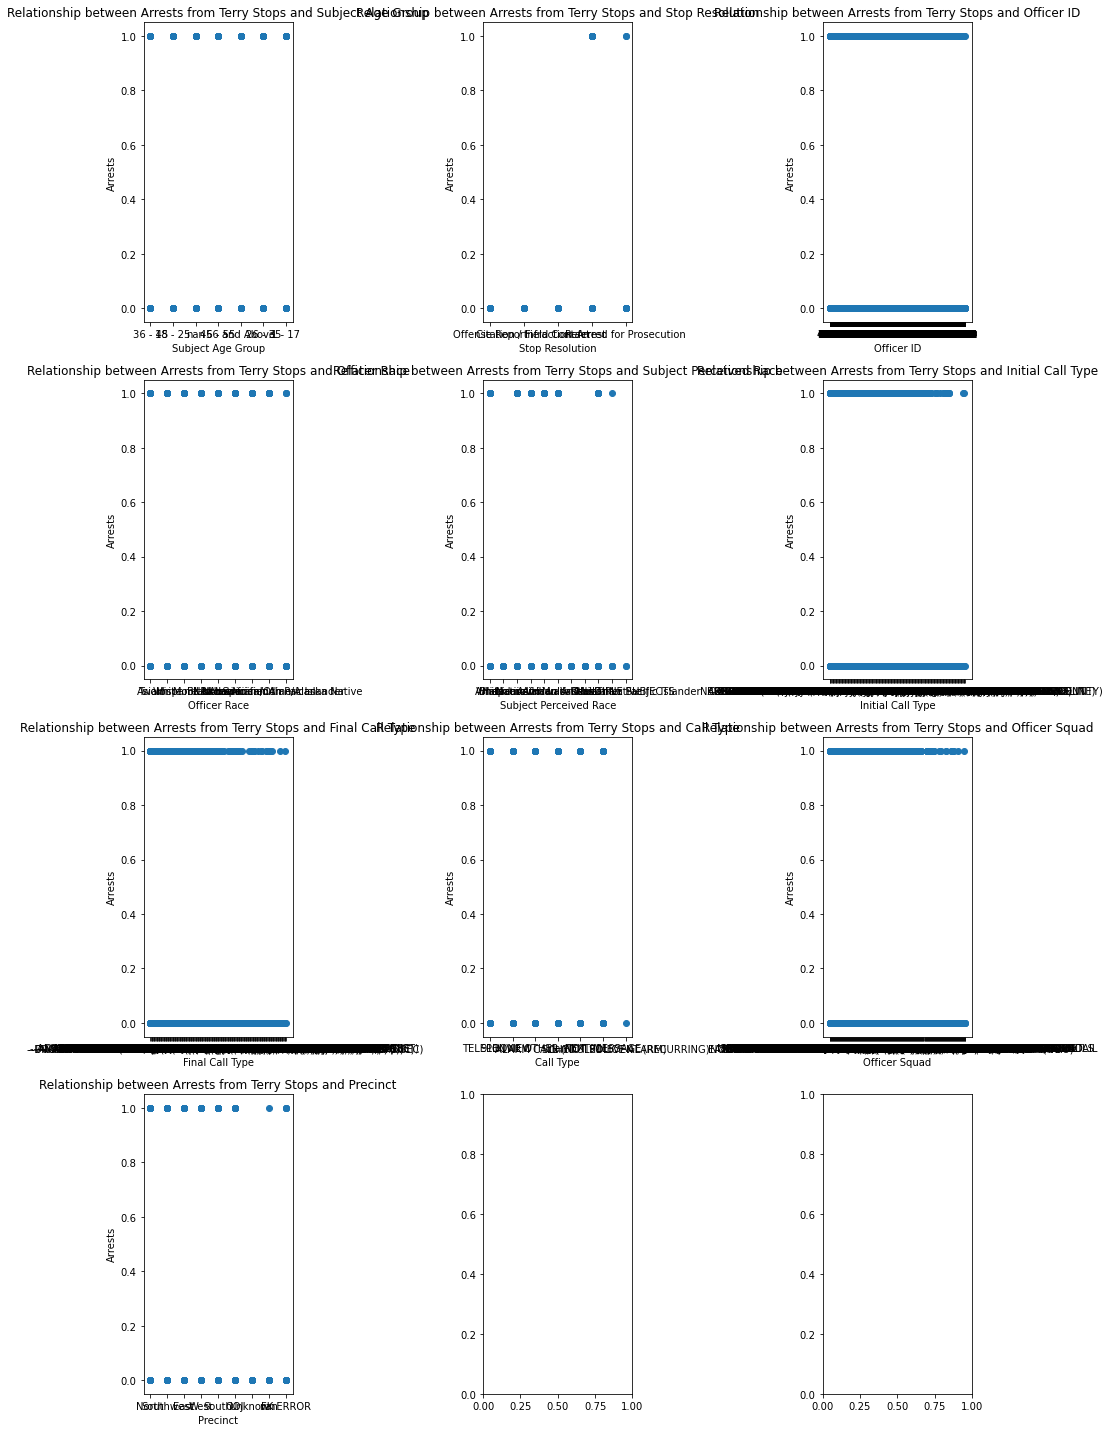

In [68]:
# Examine the relationships between 'Arrest Flag' and several independent variables through scatter plots
variables = categorical_columns
num_rows = math.ceil(len(variables) / 3)  # Calculate the number of rows for the subplots

# Set up a grid of subplots for visualizing relationships
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Plot scatter plots to explore how each independent variable affects 'Arrest Flag'
for i, var in enumerate(variables):
    row = i // 3  # Compute the row index
    col = i % 3   # Compute the column index
    
    # Convert categorical data to string to avoid type error
    x = df[var].astype(str)
    y = df['Arrest Flag']
    
    # Remove rows with missing values
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]
    
    # Scatter plot
    axes[row, col].scatter(x, y)
    axes[row, col].set_xlabel(var)  # X-axis label
    axes[row, col].set_ylabel('Arrests')  # Y-axis label
    axes[row, col].set_title(f'Relationship between Arrests from Terry Stops and {var}')  # Plot title

# Adjust layout to avoid overlap of subplots
plt.tight_layout()
plt.show()


## Discussion
* Subject Age Group: This plot shows how arrests vary across different age groups. It can help identify which age groups are more frequently involved in Terry Stops leading to arrests.
* Stop Resolution: This plot illustrates the outcomes of Terry Stops, such as whether they resulted in an arrest or another resolution. It can highlight the effectiveness or consequences of these stops.
* Officer ID: This plot shows the distribution of arrests across different officers. It can reveal if certain officers are more likely to make arrests during Terry Stops.
* Subject Perceived Race: This plot examines the relationship between the perceived race of subjects and the number of arrests. It can be used to analyze potential racial disparities in arrests.
* Precinct: This plot shows how arrests are distributed across different precincts. It can help identify areas with higher or lower arrest rates.

**Below cell code is Checking for multicollinearity**

*Multivariate analysis*

In this section, we will perform multivariate analysis to examine the relationship between the target variable - price and multiple features in the data. We will use heatmap to visualize the correlation matrix of the features and see how they are related to each other and to the price.

A heatmap can show us the strength and direction of the correlation between two variables using different colors and shades. This will help us identify the most important features for the prediction and avoid multicollinearity problems.

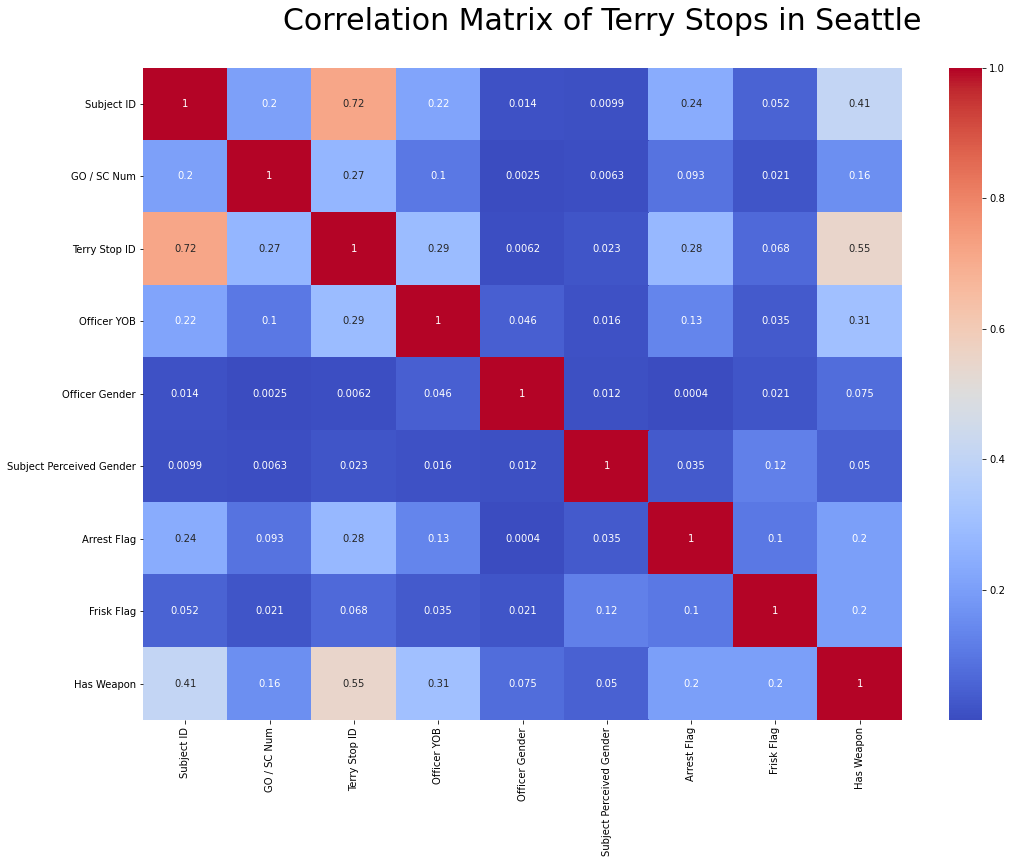

In [62]:
corr = df.corr().abs()
fig, ax=plt.subplots(figsize=(17,12))
fig.suptitle('Correlation Matrix of Terry Stops in Seattle', fontsize=30, y=.95, fontname='DejaVu Sans')
heatmap = sns.heatmap(corr, cmap='coolwarm', annot=True)
heatmap;

## Discussion
* Correlation Coefficients: The matrix shows correlation coefficients between variables, ranging from -1 to 1. Positive values indicate a direct relationship, while negative values indicate an inverse relationship.
* Strong Correlations: There are strong positive correlations between variables like ‘Arrest Flag’ and ‘Frisk Flag,’ suggesting that frisks often lead to arrests.
* Weak Correlations: Most variables show weak correlations, indicated by values close to zero. This suggests that many factors in Terry Stops are not strongly related to each other.
* Color Coding: The colors range from dark red (strong positive correlation) to dark blue (strong negative correlation), with lighter shades indicating weaker correlations.

### Transforming Categorical data using Ohe

In [81]:
# Select the categorical columns to be one-hot encoded
categorical_df = categorical_columns

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')  # sparse=False to return a dense array

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(df[categorical_df])

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_df))

# Concatenate the encoded DataFrame with the remaining columns from the original DataFrame
df_data = pd.concat([df.drop(categorical_df, axis=1), encoded_df], axis=1)

df_data


c:\Users\Bennie Kibet\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Subject ID,GO / SC Num,Terry Stop ID,Officer YOB,Officer Gender,Subject Perceived Gender,Reported Date,Reported Time,Arrest Flag,Frisk Flag,...,Officer Squad_ZOLD CRIME ANALYSIS UNIT - ANALYSTS,Officer Squad_nan,Precinct_FK ERROR,Precinct_North,Precinct_OOJ,Precinct_South,Precinct_Southwest,Precinct_Unknown,Precinct_West,Precinct_nan
0,-1.000000e+00,2.016000e+13,2.083730e+05,1953.0,0.0,0.0,2016-11-03 00:00:00+00:00,2024-08-31 15:18:00,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.000000e+00,2.018000e+13,5.591460e+05,1964.0,0.0,0.0,2018-06-22 00:00:00+00:00,2024-08-31 00:07:00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.000000e+00,2.018000e+13,4.982460e+05,1962.0,0.0,0.0,2018-11-02 00:00:00+00:00,2024-08-31 02:56:00,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.000000e+00,2.016000e+13,1.467420e+05,1974.0,0.0,2.0,2016-04-17 00:00:00+00:00,2024-08-31 01:44:00,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.000000e+00,2.015000e+13,1.044770e+05,1975.0,0.0,1.0,2015-11-29 00:00:00+00:00,2024-08-31 02:59:00,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61004,-1.000000e+00,2.016000e+13,1.670190e+05,1971.0,0.0,1.0,2016-06-22 00:00:00+00:00,2024-08-31 06:49:00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61005,-1.000000e+00,2.016000e+13,1.220590e+05,1974.0,0.0,0.0,2016-01-23 00:00:00+00:00,2024-08-31 08:34:00,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61006,1.559573e+10,2.020000e+13,1.559588e+10,1995.0,0.0,0.0,2020-09-17 00:00:00+00:00,2024-08-31 04:31:01,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61007,1.913766e+10,2.022000e+13,3.134244e+10,1987.0,0.0,0.0,2022-01-22 00:00:00+00:00,2024-08-31 15:49:44,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
df_data = df_data.dropna()

## Data splitting


In [95]:
X = df_data.drop(columns=['Arrest Flag','Reported Date','Reported Time'],axis=1)
y = df_data['Arrest Flag']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Data preprocessing

*Standardization*

* We will employ standardization to rescale the features of a Terry stop dataset so that they have a mean of zero and a variance of one.

* This process helps to normalize the features to a similar scale, which can be advantageous for machine learning algorithms that are sensitive to the scale of input features.

In [97]:
# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

>Use SMOTE to solve for class imbalance

In [98]:
smote = SMOTE(random_state=42)
#SMOTE only to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Baseline Logistic Regression Model

In [99]:
# Create an instance of Logistic Regression
logreg = LogisticRegression(solver='liblinear', random_state=42)
model_log = logreg.fit(X_train_smote,y_train_smote)
model_log
model_log.coef_

array([[ 3.08022939e-11, -5.34961909e-14,  4.34816901e-11, ...,
        -2.78157275e-23,  3.01266901e-22, -2.23471635e-23]])

In [100]:
# Predict on the training and testing data
y_train_pred = logreg.predict(X_train_smote)
y_test_pred_1 = logreg.predict(X_test)

# Calculate accuracy on the training and testing data
train_accuracy = accuracy_score(y_train_smote, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred_1)

In [102]:
#creating a function for checking for metrics 
def evaluate_model_metrics(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate evaluation metrics
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    cm_display_train = ConfusionMatrixDisplay(confusion_matrix=cm_test).plot()
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)

    # Return results
    results = {
        'roc_auc_train': roc_auc_train,
        'roc_auc_test': roc_auc_test,
        'accuracy_train': accuracy_train,
        'accuracy_test': accuracy_test,
        'confusion_matrix_train': cm_display_train
    }
    return results

In [103]:
#creating a function for checking for classification report
def generate_classification_report(y_true, y_pred):
    # Generate classification report with output_dict=True
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    
    # Convert the report to a DataFrame
    report = pd.DataFrame(report_dict).transpose()
    
    return report

In [104]:
# calling the function to get classifification report values
logreg_report = generate_classification_report(y_test, y_test_pred_1)
logreg_report

,precision,recall,f1-score,support
0.0,0.939194,0.764766,0.843052,10785.000000
1.0,0.234691,0.592988,0.336287,1312.000000
accuracy,0.746135,0.746135,0.746135,0.746135
macro avg,0.586942,0.678877,0.589670,12097.000000
weighted avg,0.862786,0.746135,0.788090,12097.000000


* Precision: The precision values for class 0 and class 1 are 0.939194 and 0.234691, respectively. Higher precision signifies a lower rate of false positives for that class. With a higher precision in class 0, the model demonstrates better performance in predicting class 0 than class 1.

* Recall: The recall values for class 0 and class 1 are 0.764766 and 0.592988, respectively. Recall measures the model's ability to correctly identify positive instances. Like precision, recall is higher for class 0, indicating better performance in identifying class 0 instances compared to class 1.

* F1-Score: The F1-scores for class 0 and class 1 are 0.843052 and 0.336287, respectively. The F1-score is the harmonic mean of precision and recall, balancing both metrics. Once again, class 0 has a higher F1-score than class 1.

* Accuracy: The model's accuracy is 0.746135, meaning that 74.61% of the predictions were correct out of all instances.

>Therefore, logistic regression achieves 74.61% prediction accuracy on the test data.
>Based on these metrics, it is evident that the model performs better for class 0 compared to class 1.

{'roc_auc_train': 0.6798585343228201,
 'roc_auc_test': 0.6788768417065255,
 'accuracy_train': 0.6798585343228201,
 'accuracy_test': 0.7461354054724312,
 'confusion_matrix_train': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x205e766b520>}

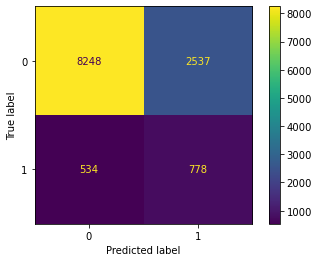

In [105]:
#metric of baseline model and draw confusion matrix
evaluate_model_metrics(logreg, X_train_smote,y_train_smote, X_test, y_test)

## Model Performance Summary
The logistic regression model demonstrates the following performance metrics:

* ROC AUC:

Training: 0.6798585343228201

Test: 0.6788768417065255

* Confusion Matrix:

True Positives (TP): 778

False Negatives (FN): 534

True Negatives (TN): 8248

False Positives (FP): 2537

* Accuracy:

Training: 0.6798585343228201

Testing: 0.7461354054724312

Observations:

* The model shows a high level of discrimination on the training data but significantly lower on the test data, suggesting potential overfitting.
* The confusion matrix indicates a considerable number of false positives, highlighting the need for model improvement.

## Cross-Validation

In [106]:
# Create an instance of Logistic Regression with cross-validation
logreg_final = LogisticRegressionCV(Cs=10, cv=5, solver='liblinear')

# Fit the model on the resampled training data
logreg_final.fit(X_train_smote, y_train_smote)

# Predict on the resampled training and testing data
y_train_pred = logreg.predict(X_train_smote)
y_test_pred = logreg.predict(X_test)

# Calculate accuracy on the resampled training and testing data
train_accuracy = accuracy_score(y_train_smote, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

{'roc_auc_train': 0.6798585343228201,
 'roc_auc_test': 0.6788768417065255,
 'accuracy_train': 0.6798585343228201,
 'accuracy_test': 0.7461354054724312,
 'confusion_matrix_train': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x205ebad7850>}

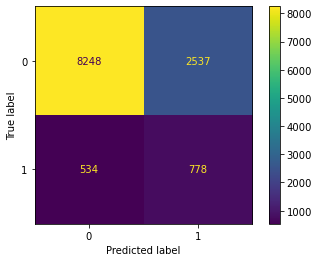

In [107]:
evaluate_model_metrics(logreg_final,X_train_smote,y_train_smote,X_test,y_test)

* After applying cross-validation with five folds, we obtained an improved model with an average accuracy of 0.7461, representing an 74.61% accuracy level in predicting arrests occuring after a Terry Stop on the test data. The training data accuracy also adjusted to 0.7461.

* This adjusted model shows no significant change in performance, accurately predicting the class labels for most instances in both training and testing datasets. The testing accuracy is slightly lower than the training accuracy, which is expected but not significantly different.

* Therefore, we can proceed to evaluate the second model to determine if it performs better in predicting arrests occuring after a Terry Stop compared to logistic regression.

## Decison Trees classifier model

In [108]:
#DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth=5, min_samples_split=5)

# Fit the model on the training data
dt_clf.fit(X_train_smote, y_train_smote)

# Predict on the training and testing data
y_train_pred_2= dt_clf.predict(X_train_smote)
y_test_pred_2 = dt_clf.predict(X_test)

# Calculate accuracy on the training and testing data
train_accuracy = accuracy_score(y_train_smote, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred_2)

{'roc_auc_train': 0.8799049165120594,
 'roc_auc_test': 0.6636373562536043,
 'accuracy_train': 0.8799049165120594,
 'accuracy_test': 0.8401256509878482,
 'confusion_matrix_train': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x205e8e66550>}

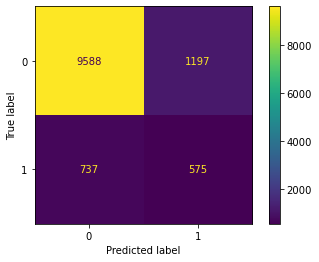

In [109]:
#checking for decison tree metrics using the predefiend function 
evaluate_model_metrics(dt_clf, X_train_smote, y_train_smote, X_test, y_test)

### Classification Report Summary

The logistic regression model exhibits the following performance metrics:

* Precision:

Class 0: 0.93

Class 1: 0.32

* Recall:

Class 0:  0.89

Class 1: 0.44

* F1-score:

Class 0: 0.91

Class 1: 0.37

* Accuracy:

Overall: 0.84

* Macro Average: 

Precision: 0.625

Recall: 0.665

F1-score: 0.64


Observations:
* High precision and recall for class 0, indicating strong performance in identifying true negatives.
* The precision is lower in class 1, suggesting the model struggles to correctly identify true positives but the recall is moderate.
* Overall accuracy of 84%, suggesting robust performance across all instances.
* The macro average shows that there is a disparity between the performance on Class 0 and Class 1, with Class 1 being harder for the model to predict correctly.
* The ROC AUC for the test set (0.66) suggests that the model has moderate discrimination ability on unseen data, although there is a notable drop from the training set's ROC AUC (0.88).
> To gain further insights, we will examine the classification report for all metrics related to the Decision Tree classifier.


In [110]:
dt_clf_report = generate_classification_report(y_test, y_test_pred_2)
dt_clf_report

,precision,recall,f1-score,support
0.0,0.928620,0.889013,0.908385,10785.000000
1.0,0.324492,0.438262,0.372892,1312.000000
accuracy,0.840126,0.840126,0.840126,0.840126
macro avg,0.626556,0.663637,0.640638,12097.000000
weighted avg,0.863098,0.840126,0.850307,12097.000000


## Random forest model

In [111]:
#random forest classifier with regularization parameters
forest_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=5, max_features='sqrt', random_state=42)

# Fit the model on the selected training data
forest_classifier.fit(X_train_smote, y_train_smote)

# Predict on the training and testing sets
y_train_pred_3 = forest_classifier.predict(X_train_smote)
y_test_pred_3 = forest_classifier.predict(X_test)

# Calculate training and testing accuracy
train_accuracy = accuracy_score(y_train_smote, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred_3)

{'roc_auc_train': 0.8747680890538033,
 'roc_auc_test': 0.7185708117077694,
 'accuracy_train': 0.8747680890538033,
 'accuracy_test': 0.775729519715632,
 'confusion_matrix_train': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x205eaa061c0>}

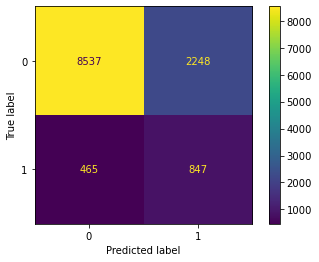

In [112]:
#checking for random forest metrics using the predefiend function 
evaluate_model_metrics(forest_classifier, X_train_smote, y_train_smote, X_test, y_test)

Confusion Matrix Breakdown

True Positives (TP): 8537
* These are instances where the model correctly predicted the positive class.

False Negatives (FN): 2248
* These are instances where the model incorrectly predicted the negative class when it was actually positive.

False Positives (FP): 465
* These are instances where the model incorrectly predicted the positive class when it was actually negative.

True Negatives (TN): 847
* These are instances where the model correctly predicted the negative class.

Insights
* High True Positives: The model is quite effective at identifying the positive class, as indicated by the high number of true positives.
* False Negatives: There is a significant number of false negatives, suggesting that the model misses a considerable portion of the positive class.
* False Positives: The number of false positives is relatively low, indicating that the model is less likely to incorrectly identify the negative class as positive.
* True Negatives: The true negatives are also relatively low, which might indicate an imbalance in the dataset or a need for model improvement.


In [113]:
generate_classification_report(y_test, y_test_pred_3)

,precision,recall,f1-score,support
0.0,0.948345,0.791562,0.862890,10785.00000
1.0,0.273667,0.645579,0.384388,1312.00000
accuracy,0.775730,0.775730,0.775730,0.77573
macro avg,0.611006,0.718571,0.623639,12097.00000
weighted avg,0.875172,0.775730,0.810993,12097.00000


>For class 0 (negative class):

* Precision: A value of 94.8% means that when the model predicts the negative class, it is correct 94.8% of the time.
* Recall: At 79.2%, this indicates that the model correctly identifies 79.2% of the actual negative instances.
* F1-score: With a value of 86.2%, this metric provides a balanced measure of precision and recall, combining both into a single value.
* Support: There are 10785 instances of the negative class in the dataset.
>For class 1 (positive class):

* Precision at 27.4% means that when the model predicts the positive class, it is accurate 27.4% of the time.
* Recall at 64.6% indicates that the model correctly identifies 64.6% of the actual positive instances.
* The F1-score at 38.4% provides a balanced measure of precision and recall for the positive class.
* Support indicates there are 1312 instances of the positive class in the dataset.
* The Random Forest classifier achieves an overall accuracy of about 77.6%, showing the percentage of correctly predicted instances overall.

### Summary

* Based on the analysis of the three models, it is evident that logistic regression performs poorly in predicting arrests after a Terry Stop.
* In contrast, both the Random Forest classifier and Decision Trees perform well with accuracies of 77.6% and 84%, respectively.
* Therefore, it is crucial to enhance the performance of the Random Forest classifier and Decision Trees by tuning hyperparameters to achieve even better accuracy.
* Hyperparameters are essential for improving the efficiency and performance of models.

### Hyperparameter Tuning
* Hyperparameters are settings that are predetermined and not learned from the data during model training.
* They govern aspects like model complexity, regularization, learning rate, and number of iterations.
* As the Random Forest classifier is our best-performing model among the three, we will employ Gridsearch to enhance its performance.

## Random Forest

In [116]:
# Create an instance of the Random Forest classifier
forest= RandomForestClassifier( random_state=42)

# Define the parameter grid for grid search
forest_param_grid = {
    'n_estimators': [100],
    'criterion': ['gini'],
    'max_depth': [2,6],
    'min_samples_split': [5],
    'min_samples_leaf': [3]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=forest, param_grid=forest_param_grid, cv=3, n_jobs=-1)

# Fit the grid search to the resampled training data
grid_search.fit(X_train_smote, y_train_smote)

# Get the best hyperparameters found during the grid search
best_params = grid_search.best_params_

# Create a new Random Forest classifier with the best hyperparameters
best_model = RandomForestClassifier(**best_params, random_state=42)

# Fit the best model to the resampled training data
best_model.fit(X_train_smote, y_train_smote)

# Predict on the training data
y_train_pred = best_model.predict(X_train_smote)

# Predict on the test data
y_test_pred = best_model.predict(X_test)

# Compute the accuracy
accuracy_train = accuracy_score(y_train_smote, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

{'roc_auc_train': 0.8867810760667905,
 'roc_auc_test': 0.6870781601592093,
 'accuracy_train': 0.8867810760667904,
 'accuracy_test': 0.7989584194428371,
 'confusion_matrix_train': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x20580593fd0>}

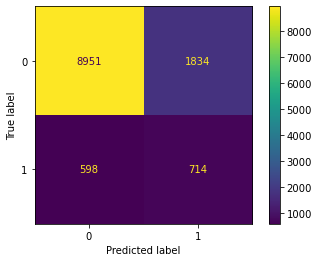

In [117]:
#using the function above the draw confusion matrix 
evaluate_model_metrics(best_model, X_train_smote, y_train_smote, X_test, y_test)

After optimizing the parameters for the Random Forest classifier using grid search, our model showed improved performance as described below:
* The accuracy of the Random Forest model now stands at 79%, indicating that it correctly predicted the class labels for the test data with around 79.9% accuracy and achieved 88.7% accuracy on the training data, making it highly effective for predicting arrests occuring after a Terry Stop.
* The confusion matrix with tuned parameters shows 714 true positives (TP), 8951 true negatives (TN), 1834 false positives (FP), and 598 false negatives (FN), demonstrating excellent predictive capability.

In [122]:
# Define the parameter grid for grid search
dt_param_grid = {
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create an instance of DecisionTreeClassifier
dt_clf_final= DecisionTreeClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=dt_clf_final, param_grid=dt_param_grid, cv=3)

# Fit the grid search to the resampled training data
grid_search.fit(X_train_smote, y_train_smote)

# Get the best hyperparameters found during the grid search
best_params = grid_search.best_params_

# Create a new DecisionTreeClassifier with the best hyperparameters
best_model_2 = DecisionTreeClassifier(**best_params,random_state=42)

# Fit the best model to the resampled training data
best_model_2.fit(X_train_smote, y_train_smote)

# Predict on the training and test data
y_train_pred = best_model_2.predict(X_train_smote)
y_test_pred = best_model_2.predict(X_test)

# Calculate accuracy on the training and test data
train_accuracy = accuracy_score(y_train_smote, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

{'roc_auc_train': 0.8799049165120594,
 'roc_auc_test': 0.6636373562536043,
 'accuracy_train': 0.8799049165120594,
 'accuracy_test': 0.8401256509878482,
 'confusion_matrix_train': <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2058606b0d0>}

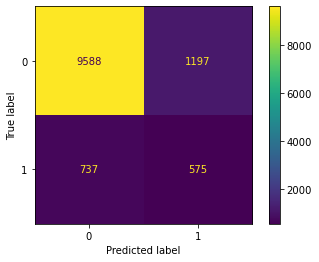

In [123]:
evaluate_model_metrics(best_model_2, X_train_smote, y_train_smote, X_test, y_test)

* The tuned Decision Tree model achieved a training accuracy of 87.5% and an improved test accuracy of 88%. This suggests that the model is performing well and has learned patterns in the data that enable accurate predictions.
* The Logistic Regression model attained an AUC-ROC score of around 0.6799 on the training data and 0.6789 on the test data.

## Evaluation
## Analysis accuracy level
* We have developed three machine learning models to predict arrests occuring after Terry Stops in Seattle. Upon testing, we found that logistic regression performs poorly, achieving a training accuracy of 74.61% and a testing accuracy of 67.98%. Despite applying 3-fold cross-validation to mitigate overfitting, the training accuracy dropped to 67.99% and the testing accuracy to 67.89%.

* In contrast, the decision tree classifier and random forest models demonstrated better accuracy. The decision tree achieved training and testing accuracies of 87.99% and 84.01%, respectively, while the random forest model had a training accuracy of 87.47% and a testing accuracy of 77.57%.

* Therefore, it is evident that the decision tree model had the best average prediction accuracy, followed by the random forest. To further improve our prediction accuracy, we applied hyperparameter tuning using GridSearch.

* After hyperparameter tuning, the decision tree model's accuracy improved to 88.7% on the training data and 79.9% on the testing data. The random forest model's accuracy improved to 88.7% on the training data and 79.9% on the testing data.

* This indicates that there was some overfitting in the random forest model, making the decision tree preferable. In terms of precision, recall, and F1 score, the tuned decision tree outperformed the random forest classifier.

## ROC curve to check the best model

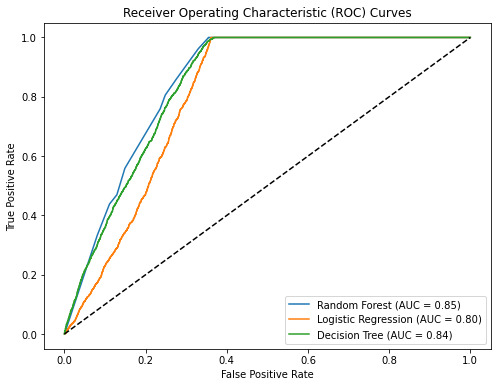

In [124]:
#drawing ROC curve for the above three models 

# Compute ROC curves and AUC scores for each model
models = [best_model_2, logreg_final, best_model]
labels = ['Random Forest', 'Logistic Regression', 'Decision Tree']

plt.figure(figsize=(8, 6))

for model, label in zip(models, labels):
    if hasattr(model, "predict_proba"):
        y_probs = model.predict_proba(X_test)[:, 1]
    else:
        y_probs = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = roc_auc_score(y_test, y_probs)

    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(label, auc_score))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

## Model Comparison Summary
Based on the AUC (Area Under the Curve) values from the ROC (Receiver Operating Characteristic) curve, the following inferences can be made about the models' performance:

* Decision Tree:

AUC: 0.84

Inference: Exhibits the strongest discriminatory power, effectively distinguishing between positive and negative classes. Maintains a high true positive rate (TPR) with a low false positive rate (FPR), resulting in a large ROC curve area.
* Random Forest:

AUC: 0.85

Inference: Demonstrates good classification ability slightly better than the Decision Tree. May have marginally lower false positive and false negative rates.
* Logistic Regression:

AUC: 0.80

Inference: Shows the weakest discriminatory performance among the three models, with potentially higher false positive and false negative rates.

Conclusion:

* The Random Forest is identified as the best model for Arrests predictions due to its largest area under the ROC curve and highest accuracy and the most improved hence best in predicting Arrest occuring after Terry Stops.
* The Decision Tree also performs well but is slightly less effective than the Random Forest.
* The Logistic Regression model, while useful, has the lowest AUC, indicating comparatively weaker performance in distinguishing between classes.

## Conclusion
> By leveraging the best model, which is the Random Forest, the public safety department can achieve significant benefits:

* Accurate Prediction of arrests after a Terry stop: The model's high accuracy ensures effective identification of arrests likely to occur, enabling preparation on how to prosecute such cases.
* Resource Allocation: Efficient Use of Resources: By predicting the likelihood of an arrest following a Terry stop, departments can allocate resources more effectively. This ensures that officers are deployed where they are most needed, potentially reducing response times and improving overall efficiency.
* Crime Prevention through proactive Policing: Predictive models can help identify patterns and hotspots for criminal activity. This allows officers to be more proactive in their patrols, potentially preventing crimes before they occur.
* Improved Training and Policies through data-driven decisions: Analysis of predictive data can inform training programs and policy adjustments. Departments can identify areas where officers may need additional training or where policies might need to be revised to improve outcomes.
* Community Trust (Transparency and Accountability): Using data to predict arrests can increase transparency in policing practices. When the public sees that decisions are based on data and not bias, it can help build trust between the community and the police.
* Legal and Ethical Compliance reducing bias: Predictive models can help ensure that Terry stops are conducted based on objective criteria rather than subjective judgment, potentially reducing instances of biased policing.
* Enhanced Officer Safety: Predicting the likelihood of an arrest can also help assess the risk level of a situation, allowing officers to take necessary precautions to ensure their safety.

